---

<div align=center>

# **Initialization**

</div>

## Imports

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from LRFutils import archive, progress
from src import plot
from scipy.special import wofz
from multiprocess import Pool, cpu_count
import os
import pyvtk as vtk
import psutil
from astropy import units as u
from astropy.constants import h, k_B as k, c

## Constants

In [77]:
T = 10 * u.K
pi = np.pi
h = h.to(u.erg * u.s)
c = c.to(u.cm / u.s)

## Class definitions

In [78]:
class Gas:
    def __init__(
            self,
            name=None,
            f=None,
            profile=None,
            density_cube=None,
            velocity_cube=None,
            v0=None,
            sigma_v=None,
            A12=None,
            B12=None,
            B21=None,
            emissivity=None,
            absorption=None,
            g2_over_g1=None,
        ):
        self.name = name
        self.f = f
        self.profile = profile
        self.density_cube = density_cube
        self.velocity_cube = velocity_cube
        self.v0 = v0
        self.sigma_v = sigma_v
        self.A12 = A12
        self.emissivity = emissivity
        self.absorption = absorption
        self.g2_over_g1 = g2_over_g1

    @property
    def n2_over_n1(self):
        return self.g2_over_g1 * np.exp(-h*self.v0 / (k*T))

    @property
    def n1(self):
        return self.density_cube - self.density_cube / (1/self.n2_over_n1 + 1)
    
    @property
    def n2(self):
        return self.density_cube / (1/self.n2_over_n1 + 1)

    @property
    def B21(self):
        return self.A21 * c**3 / (8 * np.pi * h * self.v0**3)
    
    @property
    def B12(self):
        return self.g2_over_g1 * self.B21

## Functions definitions

In [79]:
def gaussian(x, m=0.5, s=0.05):
    return np.exp(- (x - m)**2 / (2 * s**2))

def lorentzian(x, mu, gamma):
    return gamma / (np.pi * ((x - mu)**2 + gamma**2))

def plummer(r, R=0.75):
    return 3/(4*np.pi*R**3)*(1 + r**2 / R**2)**(-5/2)

def voigt_profile(freq_range, sigma, gamma):
    x = freq_range
    y = np.zeros_like(x)
    for i, x_i in enumerate(x):
        z = (x_i + 1j * gamma) / (sigma * np.sqrt(2))
        y[i] = np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))
    return y

def sigmoid(x, d=0.5, l=10):
    return 1/(1+np.exp(-l*(x-d)))

def black_body(f, T):
    return 2 * h * f**3 / c**2 / (np.exp(h * f / k / T) - 1)

def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

## Configuration

In [82]:
nb_simu = 1000 # number of generated simulations
# ⚠️ Be carefull, the final dataset will be proportional to nb_images = 6 * nb_simu

# Global
N = 64 # resolution in pixel
r, dr = np.linspace(-1, 1, N, endpoint=True, retstep=True)
r = r * u.pc
dr = dr * u.pc

# Plummer profile (density)
plummer_radius = 0.5 * u.pc
max_density = 1e6 / u.cm**3 # hydrogen abundance

CO_fractional_abundance = 1e-4 # particle / hydrogen atom
N2H_fractional_abundance = 1e-7 # particle / hydrogen atom

# Sigmoid parameters (repartition of the gas)
sigmoid_treshold = max_density/2
sigmoid_slope = 50/max_density

# CO
CO = Gas(
    name="CO",
    v0 = 115.27120e9 * u.Hz,
    )
CO.sigma_v = CO.v0 / c * 1*u.cm/u.s
CO.f = np.linspace(CO.v0 - 5*CO.sigma_v, CO.v0 + 5*CO.sigma_v, N)
CO.profile = gaussian(CO.f, CO.v0, CO.sigma_v) / u.Hz
CO.A21 = 7.203e-8 / u.s
CO.g2_over_g1 = 3
# CO.B21 = 2.574e-6 * u.cm**2 / u.erg / u.s  # ⚠️
# CO.B12 = 2.713e-6 * u.cm**2 / u.erg / u.s

print("n1/n2 for CO:", CO.n2_over_n1)

# N2H+
N2H = Gas("N2H+")
N2H.v0 = 93.17371e9 * u.Hz
N2H.sigma_v = N2H.v0 / c * 1*u.m/u.s
N2H.f = np.linspace(N2H.v0 - 5*N2H.sigma_v, N2H.v0 + 5*N2H.sigma_v, N)
N2H.profile = gaussian(N2H.f, N2H.v0, N2H.sigma_v) / u.Hz
N2H.A21 = 3.929e-5 / u.s
N2H.g2_over_g1 = 3 # TODO
# N2H.B21 = 1.226e-5 * u.cm**2 / u.erg / u.s
# N2H.B12 = 2.832e-5 * u.cm**2 / u.erg / u.s

print("n1/n2 for N2H+:", N2H.n2_over_n1)

n1/n2 for CO: 1.7252945344373711
n1/n2 for N2H+: 1.9183184717269368


In [83]:
print("h:  ", f"{h:.3e}")
print("c:  ", f"{c:.3e}")
print("A21:", f"{CO.A21:.3e}")
print("v0: ", f"{CO.v0:.3e}")
print("B21:", f"{CO.B21:.3e}")
print("B12:", f"{CO.B12:.3e}")

h:   6.626e-27 erg s
c:   2.998e+10 cm / s
A21: 7.203e-08 1 / s
v0:  1.153e+11 Hz
B21: 7.609e+15 cm3 / (erg Hz3 s5)
B12: 2.283e+16 cm3 / (erg Hz3 s5)


## Verification

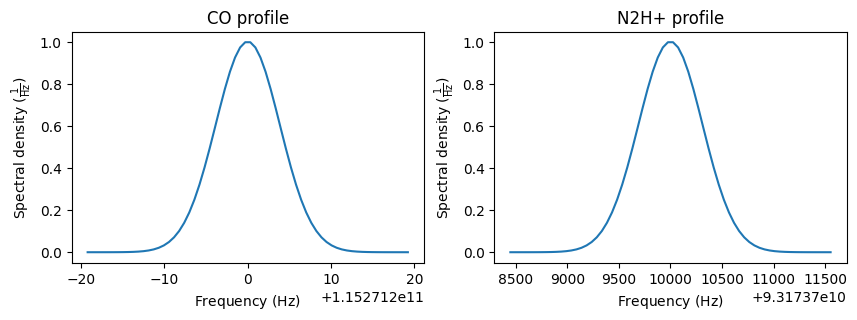

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(CO.f, CO.profile)
plt.title("CO profile")
plt.xlabel(f"Frequency ({CO.f.unit.to_string('latex')})")
plt.ylabel(f"Spectral density ({CO.profile.unit.to_string('latex')})")
plt.subplot(122)
plt.plot(N2H.f, N2H.profile)
plt.title("N2H+ profile")
plt.xlabel(f"Frequency ({N2H.f.unit.to_string('latex')})")    
plt.ylabel(f"Spectral density ({N2H.profile.unit.to_string('latex')})")
plt.show()

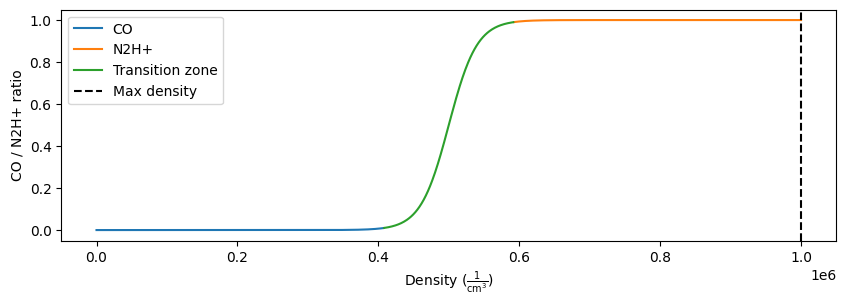

In [ ]:
plt.figure(figsize=(10, 3))
tmp = max(max_density, 2*sigmoid_treshold)
tmp = np.linspace(0, tmp, 1000)
print((sigmoid_treshold*sigmoid_slope).unit)
tmp2 = sigmoid(tmp, sigmoid_treshold, sigmoid_slope)
plt.plot(tmp[tmp2 < 0.01], tmp2[tmp2 < 0.01], label="CO")
plt.plot(tmp[tmp2 > 0.99], tmp2[tmp2 > 0.99], label="N2H+")
plt.plot(tmp[(tmp2 > 0.01) & (tmp2 < 0.99)], tmp2[(tmp2 > 0.01) & (tmp2 < 0.99)], label="Transition zone")
plt.axvline(max_density.value, color="k", linestyle="--", label="Max density")
plt.xlabel(f"Density ({max_density.unit.to_string('latex')})")
plt.ylabel("CO / N2H+ ratio")
plt.legend()
plt.show()

## Environment variables

In [ ]:
X, Y, Z = np.meshgrid(r, r, r)
R = np.sqrt(X**2 + Y**2 + Z**2)

archive_path = archive.new("Generation", verbose=True)

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

Archive created at ./archives/2023-03-10_7fb0ca2/7_Generation


---

<div align=center>

# **Cloud density generation**

</div>

In [ ]:
p = plummer(R, plummer_radius)
H = Gas("H")
H.density_cube = max_density * p / np.max(p)
CO.density_cube = H.density_cube * (1 - sigmoid(H.density_cube, sigmoid_treshold, sigmoid_slope))
CO. density_cube = CO_fractional_abundance * CO.density_cube * np.max(H.density_cube) / np.max(CO.density_cube)
N2H.density_cube = H.density_cube * sigmoid(H.density_cube, sigmoid_treshold, sigmoid_slope)
N2H. density_cube = N2H_fractional_abundance * N2H.density_cube * np.max(H.density_cube) / np.max(N2H.density_cube)

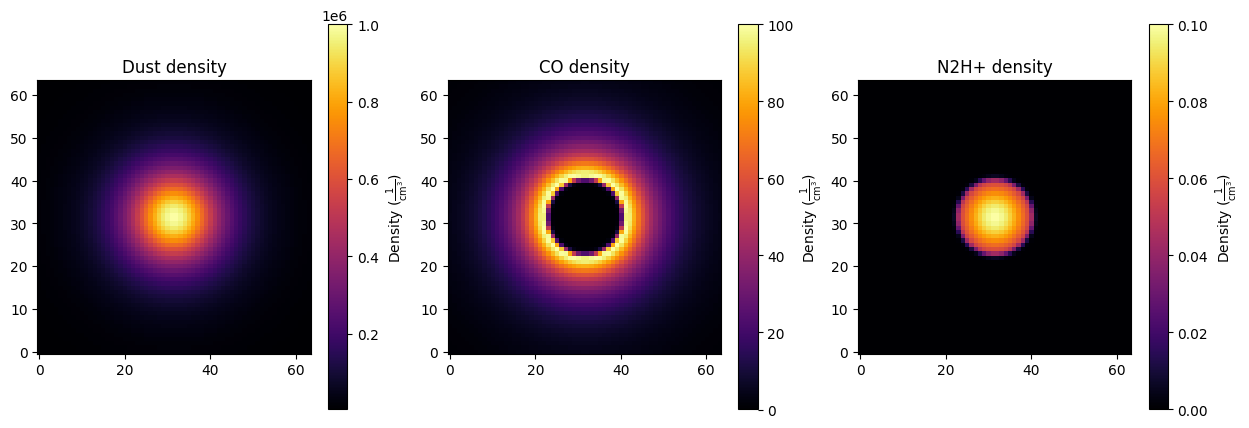

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(131)    
im = plt.imshow(H.density_cube[N//2].value, origin="lower", cmap="inferno")
cbar = plt.colorbar(im)
cbar.set_label(f"Density ({H.density_cube.unit.to_string('latex')})")
plt.title("Dust density")

plt.subplot(132)
im = plt.imshow(CO.density_cube[N//2].value, origin="lower", cmap="inferno")
cbar = plt.colorbar(im)
cbar.set_label(f"Density ({CO.density_cube.unit.to_string('latex')})")
plt.title("CO density")

plt.subplot(133)
im = plt.imshow(N2H.density_cube[N//2].value, origin="lower", cmap="inferno")
cbar = plt.colorbar(im)
cbar.set_label(f"Density ({N2H.density_cube.unit.to_string('latex')})")
plt.title("N2H+ density")

plt.show()

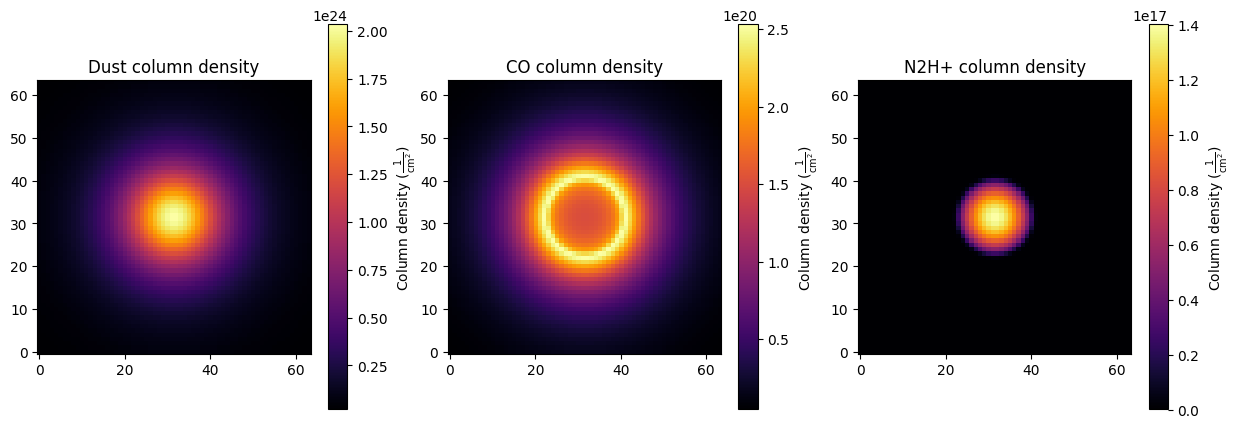

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(131) 
im = plt.imshow((np.sum(H.density_cube, axis=0) * dr.to(u.cm)).value, origin="lower", cmap="inferno")
cbar = plt.colorbar(im)
cbar.set_label(f"Column density ({(H.density_cube * u.cm).unit.to_string('latex')})")
plt.title("Dust column density")

plt.subplot(132)
im = plt.imshow((np.sum(CO.density_cube, axis=0) * dr.to(u.cm)).value, origin="lower", cmap="inferno")
cbar = plt.colorbar(im)
cbar.set_label(f"Column density ({(CO.density_cube * u.cm).unit.to_string('latex')})")
plt.title("CO column density")

plt.subplot(133)
im = plt.imshow((np.sum(N2H.density_cube, axis=0) * dr.to(u.cm)).value, origin="lower", cmap="inferno")
cbar = plt.colorbar(im)
cbar.set_label(f"Column density ({(N2H.density_cube * u.cm).unit.to_string('latex')})")
plt.title("N2H+ column density")

plt.show()

---

<div align=center>

# **Cloud velocity generation**

</div>

In [ ]:
CO.velocity_cube = np.zeros((N, N, N)) * u.km / u.s
N2H.velocity_cube = np.zeros((N, N, N)) * u.km / u.s

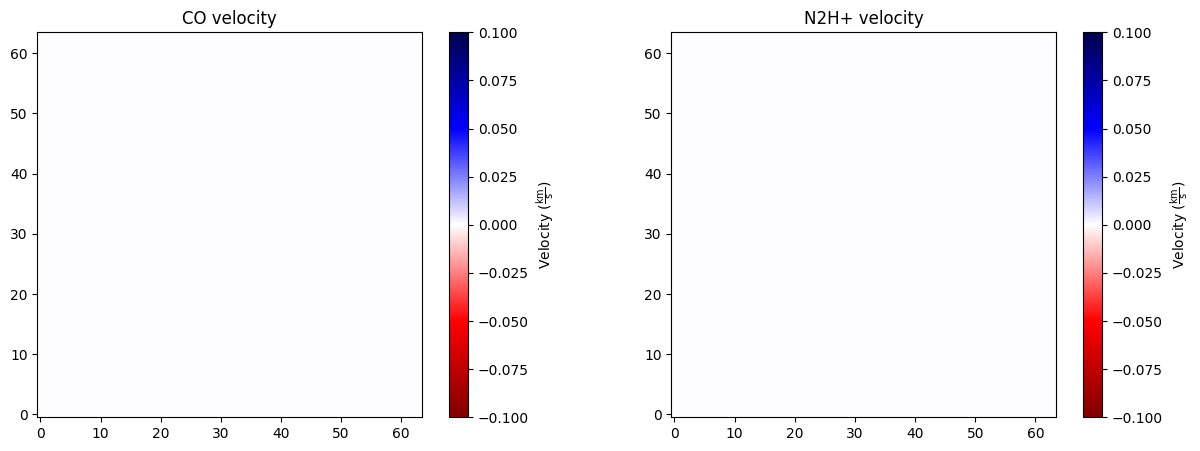

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
im = plt.imshow(CO.velocity_cube[N//2].value, origin="lower", cmap="seismic_r")
cbar = plt.colorbar(im)
cbar.set_label(f"Velocity ({CO.velocity_cube.unit.to_string('latex')})")
plt.title("CO velocity")

plt.subplot(122)
im = plt.imshow(N2H.velocity_cube[N//2].value, origin="lower", cmap="seismic_r")
cbar = plt.colorbar(im)
cbar.set_label(f"Velocity ({N2H.velocity_cube.unit.to_string('latex')})")
plt.title("N2H+ velocity")

plt.show()

---

<div align=center>

# **Radiative transfer**

</div>

### Emmissivity and absorption

In [ ]:
def get_absorption(gas, f):
    return h * gas.v0 / (4 * pi) * (gas.n1 * gas.B12 - gas.n2 * gas.B21) * gas.profile[f]

def get_emission(gas, f):
    return h * gas.v0 / (4 * pi) * (gas.A21 * gas.n2) * gas.profile[f]

for gas in [CO, N2H]:
    gas.emissivity_hypercube = np.zeros((N, N, N, len(gas.f)))
    gas.absorption_hypercube = np.zeros((N, N, N, len(gas.f)))

    for f in range(len(gas.f)):
        gas.absorption_hypercube[:,:,:,f] = get_absorption(gas, f).value
        gas.emissivity_hypercube[:,:,:,f] = get_emission(gas, f).value

    gas.absorption_hypercube *= get_absorption(gas, 0).unit
    gas.emissivity_hypercube *= get_emission(gas, 0).unit

print(f"h unit: {h.unit}")
print(f"CO profile unit: {CO.profile.unit}")
print(f"CO v0 unit: {CO.v0.unit}")
print(f"CO n1 unit: {CO.n1.unit}")
print(f"CO n2 unit: {CO.n2.unit}")
print(f"CO B12 unit: {CO.B12.unit}")
print(f"CO B21 unit: {CO.B21.unit}")
print(f"CO A21 unit: {CO.A21.unit}")
print(f"CO absorption unit: {CO.absorption_hypercube.unit}")
print(f"CO emissivity unit: {CO.emissivity_hypercube.unit}")

AttributeError: 'Gas' object has no attribute 'B12'

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5)) 

for i, gas in enumerate([CO, N2H]):

    ax1 = axs[i]
    ax2 = axs[i].twinx()

    plot_1 = ax1.plot(gas.f, gas.emissivity_hypercube[N//2,N//2,N//2,:], "b+-", label="Emissivity")
    plot_2 = ax2.plot(gas.f, gas.absorption_hypercube[N//2,N//2,N//2,:], "gx-", label="Absorption")
    axs[0].set_xlabel(f"Frequency ({gas.f.unit})")
    ax1.set_ylabel(f"Emission ({gas.emissivity_hypercube.unit})")
    ax2.set_ylabel(f"Ebsorption ({gas.absorption_hypercube.unit})")

    lns = plot_1 + plot_2
    labels = [l.get_label() for l in lns]
    plt.legend(lns, labels, loc=0)

axs[0].set_title("CO (at the center of the cloud)")
axs[1].set_title("N2H+ (at the center of the cloud)")

plt.show()

## Light propagation

<div align=center>

> # ⚠️ WARNING ⚠️
> 
> ### The absorption coefficient is currently arbitrarily increased by a factor of 500 to have similar results as the one we expect.

</div>


In [ ]:
dN = dr.to(u.cm)

for gas in [CO, N2H]:

    kappa = gas.absorption_hypercube * 500 # ⚠️ HERE ⚠️
    epsilon = gas.emissivity_hypercube
    
    print("Gas :", gas.name)
    print("  Epsilon")
    print("    Min :", np.amin(epsilon))
    print("    Max :", np.amax(epsilon))
    print("  Kappa")
    print("    Min :", np.amin(kappa))
    print("    Max :", np.amax(kappa))

    # Integrating the equation of radiative transfer
    gas.observation = np.zeros((N, N, len(gas.f))) * epsilon.unit * dN.unit
    
    fig, axs = plt.subplots(6, 9, figsize=(25, 10))
    cpt = 0
    axs[0,0].set_ylabel(r"$\kappa_\nu \Delta n$")
    axs[1,0].set_ylabel(r"$\tau_\nu(s' \rightarrow S)$")
    axs[2,0].set_ylabel(r"$e^{-\tau_\nu(s' \rightarrow S)}$")
    axs[3,0].set_ylabel(r"$\epsilon_\nu \Delta n$")
    axs[4,0].set_ylabel(r"$\epsilon_\nu e^{-\tau_\nu(s' \rightarrow S)}\Delta n$")
    axs[5,0].set_ylabel(r"$I_\nu(S)$")

    for i in range(0,N):

        # Computing Tau_s
        tau = np.zeros((N, N, len(gas.f)))
        for j in np.arange(i, N):
            tau += (kappa[j] * dN).value
        
        tau *= kappa.unit * dN.unit

        layer_contrib = epsilon[i] * np.exp(-tau) * dN
        gas.observation += layer_contrib

        if i % (N//8) == 0 or i == N-1:

            kappa_dN = kappa[i][:,:,N//2] * dN
            im = axs[0, cpt].imshow(kappa_dN.value, origin="lower")
            cbar = plt.colorbar(im)
            cbar.set_label(kappa_dN.unit.to_string("latex_inline"))

            im = axs[1, cpt].imshow(tau[:,:,N//2].value, origin="lower")
            cbar = plt.colorbar(im)
            cbar.set_label(tau.unit.to_string("latex_inline"))

            im = axs[2, cpt].imshow(np.exp(-tau)[:,:,N//2].value, origin="lower", cmap="gray")
            cbar = plt.colorbar(im)
            cbar.set_label(np.exp(-tau).unit.to_string("latex_inline"))

            epsilon_dN = epsilon[i][:,:,N//2] * dN
            im = axs[3, cpt].imshow(epsilon_dN.value, origin="lower", cmap="inferno")
            cbar = plt.colorbar(im)
            cbar.set_label(epsilon_dN.unit.to_string("latex_inline"))

            im = axs[4, cpt].imshow(layer_contrib[:,:,N//2].value, origin="lower", cmap="inferno")
            cbar = plt.colorbar(im)
            cbar.set_label(layer_contrib.unit.to_string("latex_inline"))

            im = axs[5, cpt].imshow(gas.observation[:,:,N//2].value, origin="lower", cmap="inferno")
            cbar = plt.colorbar(im)
            cbar.set_label(gas.observation.unit.to_string("latex_inline"))

            cpt += 1

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(CO.observation[:,:,N//2].value, origin="lower", cmap="inferno")
plt.colorbar()
plt.title("CO observation")
plt.subplot(222)
plt.plot(CO.f.value, CO.observation[N//2,N//2,:].value)
plt.title("CO spectrum (at the center of the cloud)")
plt.xlabel(f"Frequency ({CO.f.unit.to_string('latex_inline')}))")
plt.ylabel(f"Intensity ({CO.observation.unit.to_string('latex_inline')})")
plt.subplot(223)
plt.imshow(N2H.observation[:,:,N//2].value, origin="lower", cmap="inferno")
plt.colorbar()
plt.title("N2H+ observation")
plt.subplot(224)    
plt.plot(N2H.f.value, N2H.observation[N//2,N//2,:].value)
plt.title("N2H+ spectrum (at the center of the cloud)")
plt.xlabel(f"Frequency ({N2H.f.unit.to_string('latex_inline')})")    
plt.ylabel(f"Intensity ({N2H.observation.unit.to_string('latex_inline')})")
plt.show()

---

<div align=center>

# **LOC simulation**

</div>


## Save data as LOC inputs

Following the [LOC documentation](interstellarmedium.org/radiative_transfer/loc/)

In [ ]:
# Model cloud description

header = np.array([N, N, N,], dtype=np.int32)
model = np.zeros((N, N, N, 7), dtype=np.float32)

model[:,:,:,0] = H.density_cube.value # cloud density
model[:,:,:,1] = T # kinetic temperature
model[:,:,:,2] = 0 # microturbulence
model[:,:,:,3] = 0 # macroscopic velocity (x)
model[:,:,:,4] = 0 # macroscopic velocity (y)
model[:,:,:,5] = 0 # macroscopic velocity (z)
model[:,:,:,6] = CO_fractional_abundance # fractional abundance

with open("data/LOC/CO/input_cloud.bin", "wb") as file:
    header.tofile(file)
    model.tofile(file)

In [ ]:
# Initialisation file

config = f"""\
cloud          data/LOC/CO/input_cloud.bin    #  cloud defined on a Cartesian grid
distance       7200.0                         #  cloud distance [pc]
angle          1.0                            #  model cell size  [arcsec]
molecule       data/LOC/CO/input_molecule.dat #  name of the Lamda file
density        1.0                            #  scaling of densities in the cloud file
temperature    1.0                            #  scaling of Tkin values in the cloud file
fraction       1.0e-4                         #  scaling o the fraction abundances
velocity       1.0                            #  scaling of the velocity
sigma          1.0                            #  scaling o the microturbulence
isotropic      2.73                           #  Tbg for the background radiation field
levels         3                              #  number of energy levels in the calculations
uppermost      3                              #  uppermost level tracked for convergence
iterations     5                              #  number of iterations
nside          2                              #  NSIDE parameter determining the number of rays (angles)
direction      90 0.001                       #  theta, phi [deg] for the direction towards the observer
points         64 64                          #  number of pixels in the output maps
grid           1.0                            #  map pixel size [arcsec]
spectra        1 0  2 1                       #  spectra written for transitions == upper lower (pair of integers)
transitions    1 0  2 1                       #  Tex saved for transitions (upper and lower levels of each transition)
bandwidth      6.0                            #  bandwidth in the calculations [km/s]
channels       128                            #  number of velocity channels
prefix         data/LOC/CO/output/res         #  prefix for output files
load           load_level_pop                 #  load level populations
save           save_level_pop                 #  save level populations
stop          -1.0                            #  stop if level-populations change below a threshold
gpu            1                              #  gpu>0 => use the first available gpu
"""

with open("data/LOC/CO/input_config.ini", "w") as file:
    file.write(config)

## Running LOC simulation

In [ ]:
!python src/LOC/LOC_OT.py data/LOC/CO/input_config.ini

if os.name == "nt":
    !move CO.dump data/LOC/CO/output/
    !move gauss_py.dat data/LOC/CO/output/
    !move save_level_pop data/LOC/CO/output/
else:
    !mv CO.dump  data/LOC/CO/output/
    !mv gauss_py.dat data/LOC/CO/output/
    !mv save_level_pop data/LOC/CO/output/

## Loading the results

In [ ]:
import os, sys
from matplotlib.pylab import *

def LOC_read_spectra_3D(filename):
    """
    Read spectra written by LOC.py (LOC_OT.py; 3D models)
    Usage:
        V, S = LOC_read_spectra_3D(filename)
    Input:
        filename = name of the spectrum file
    Return:
        V  = vector of velocity values, one per channel
        S  = spectra as a cube S[NRA, NDE, NCHN] for NRA
             times NDE points on the sky,
             NCHN is the number of velocity channels
    """
    fp              =  open(filename, 'rb')
    NRA, NDE, NCHN  =  fromfile(fp, int32, 3)
    V0, DV          =  fromfile(fp, float32, 2)
    SPE             =  fromfile(fp, float32).reshape(NRA, NDE,2+NCHN)
    OFF             =  SPE[:,:,0:2].copy()
    SPE             =  SPE[:,:,2:]
    fp.close()
    return V0+arange(NCHN)*DV, SPE
    
    
def LOC_read_Tex_3D(filename):
    """
    Read excitation temperatures written by LOC.py (LOC_OT.py) -- in case of
    a Cartesian grid (no hierarchical discretisation).
    Usage:
        TEX = LOC_read_Tex_3D(filename)
    Input:
        filename = name of the Tex file written by LOC1D.py
    Output:
        TEX = Vector of Tex values [K], one per cell.
    Note:
        In case of octree grids, the returned vector must be
        compared to hierarchy information (e.g. from the density file)
        to know the locations of the cells.
        See the routine OT_GetCoordinatesAllV()
    """
    fp    =  open(filename, 'rb')
    NX, NY, NZ, dummy  =  fromfile(fp, int32, 4)
    TEX                =  fromfile(fp, float32).reshape(NZ, NY, NX)
    fp.close()
    return TEX 

## Plotting the results

In [ ]:
V, T10 = LOC_read_spectra_3D('data/LOC/CO/output/res_CO_01-00.spe')
V, T21 = LOC_read_spectra_3D('data/LOC/CO/output/res_CO_02-01.spe')
Tex10  = LOC_read_Tex_3D('data/LOC/CO/output/res_CO_01-00.tex')
Tex21  = LOC_read_Tex_3D('data/LOC/CO/output/res_CO_02-01.tex')
NY, NX, NCHN = T10.shape  # number of pixels and channels

# One spectrum from (about) the model centre
subplot(221)
plot(V, T10[NY//2, NX//2, :], 'b-', label='T(1-0)')
plot(V, T21[NY//2, NX//2, :], 'r-', label='T(2-1)')
legend(loc='lower center')
title("Centre spectra (K)")
xlabel(r'$v \/ \/ \rm (km s^{-1})$')
ylabel(r'$T \rm _A \/ \/ (K)$')

# Cross section of the Tex(1-0) cube
subplot(222)
imshow(Tex10[:,:, Tex10.shape[2]//2])
title("J=1-0 excitation temperature (K)")
colorbar()

# Cross section of the Tex(2-1) cube
subplot(223)
imshow(Tex21[:,:, Tex21.shape[2]//2])
title("J=2-1 excitation temperature (K)")
colorbar()

# J=1-0 line area
subplot(224)
W     =  (V[1]-V[0])*sum(T10, axis=2)
imshow(W)
title("Line Area W(1-0) (K km/s)")
colorbar()

show()

In [ ]:
im = imshow(T10[:, :, T10.shape[-1]//2], origin='lower', cmap="inferno")
cbar = colorbar(im)
cbar.set_label(r'$T_A \rm _{1-0} \/ \/ (K)$')
plt.title("J=1-0 excitation temperature (K) at v=0 km/s")